# Neural Style Transfer

It consists of two parts-                                                                                          
    1: Implementing neural style transfer algorithm.                                                               
    2: Uisng it to generate novel artistic images.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline



# 1 - Problem statement

Neural Style Transfer (NST) is technique in deep learning which merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.                                                                               
C + S = G

# 2 - Use of transfer Learning
Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.             
we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers).

In [2]:
model = load_vgg_model("/home/pankaj/projects/neural style transfer/imagenet-vgg-verydeep-19.mat")
print(model)

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 25

# 3 - Implementation of NST algo-
 Three step process-                                                                                               
  1: Build the content cost function $J_{content}(C,G)$                                                            
  2: Build the style cost function $J_{style}(S,G)$                                                                 
  3: Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.


## 3.1: Computing content cost

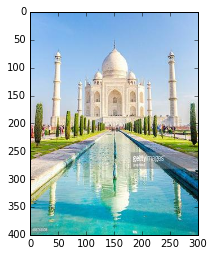

In [3]:
content_image = scipy.misc.imread("/home/pankaj/projects/neural style transfer/468743538.jpg")
imshow(content_image)

### 3.1.1 - To ensure the generated image G matches the content of the image C

The earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes.

We would like the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image. In practice, we'll get the most visually pleasing results if we choose a layer in the middle of the network--neither too shallow nor too deep. 

So, suppose we have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer we had chosen.  This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$
Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer we have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)
                                                                                                                     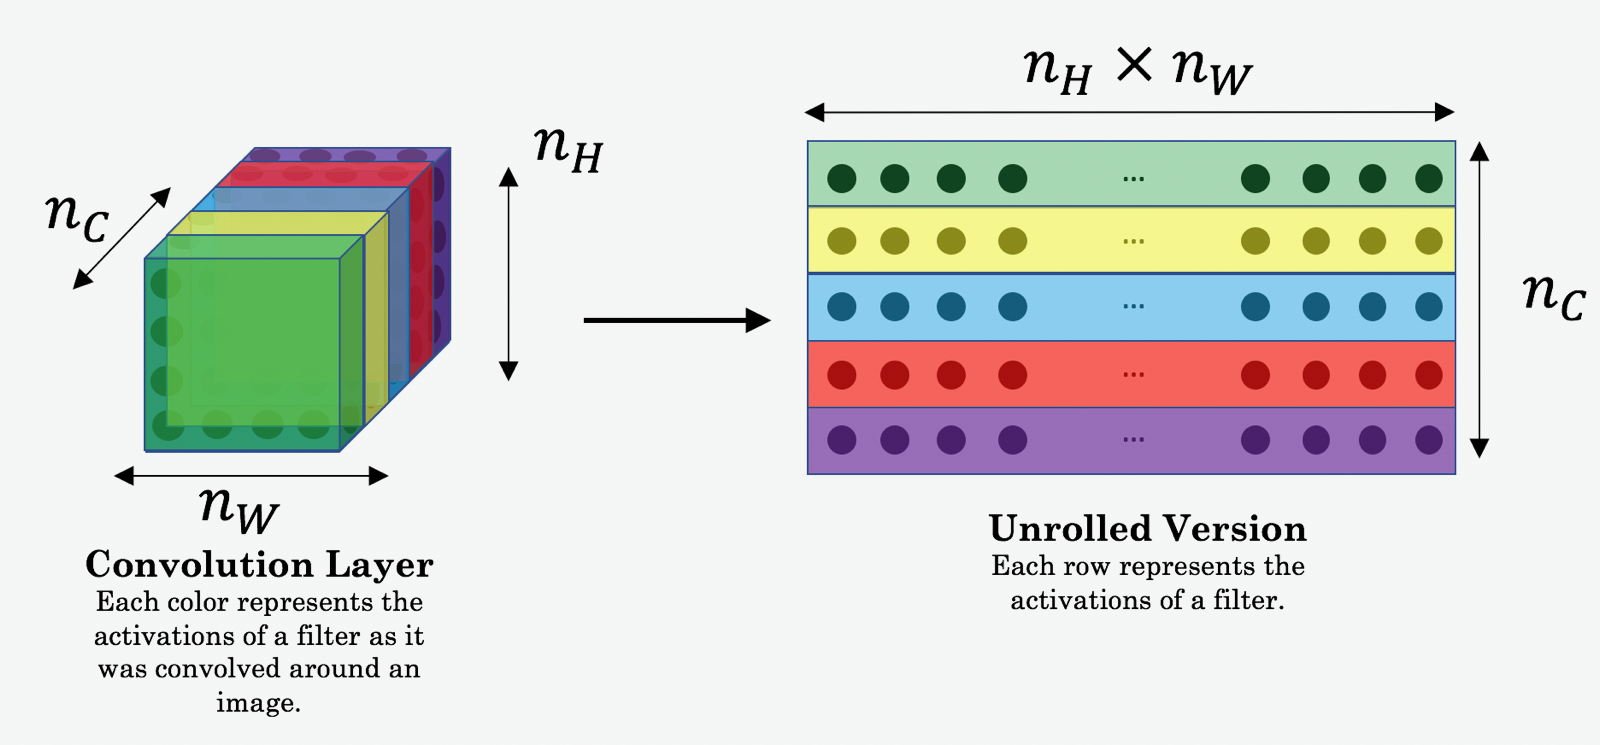                                                                                                                                                                                                                                       Exercise: Compute the "content cost" using TensorFlow.
                                                                                                                   
Instructions: The 3 steps to implement this function are:<br/>                                                                 -Retrieve dimensions from a_G:<br/>                                                                                          To retrieve dimensions from a tensor X, use: X.get_shape().as_list()    <br/>                             -Unroll a_C and a_G as explained in the picture above.   <br/>                                                     -Compute the content cost: <br/>


In [4]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [-1]))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2) / (4 * n_H * n_W * n_C)
    ### END CODE HERE ###
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


## 3.2 Computing the style cost
 ### 3.2.1 Style matrix
The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large.

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context.

In NST, we can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:
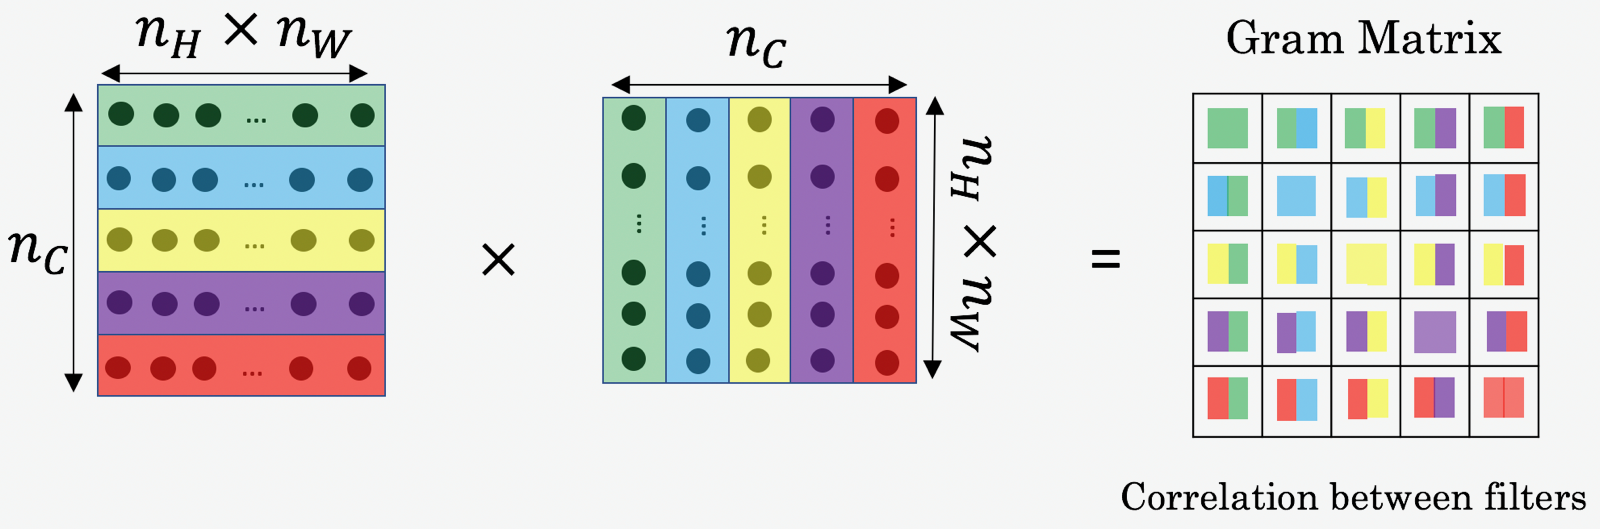


The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture.

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image.

Exercise: Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. The formula is: The gram matrix of A is $G_A = AA^T$.

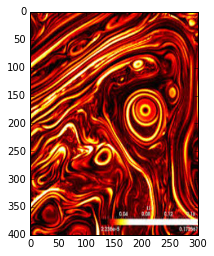

In [6]:
style_image = scipy.misc.imread("/home/pankaj/projects/neural style transfer/images (2).jpeg")
imshow(style_image)

In [7]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A, tf.transpose(A)) # '*' is elementwise mul in numpy
    ### END CODE HERE ###
    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))


GA = [[  6.42230511  -4.42912245  -2.09668207]
 [ -4.42912245  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


### 3.2.2 - Style cost
After generating the Style matrix (Gram matrix), our goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$
where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.

- Compute the style cost for a single layer.

Instructions: The 3 steps to implement this function are:                                                           
  1: Retrieve dimensions from the hidden layer activations a_G:                        <br>                                      To retrieve dimensions from a tensor X, use: X.get_shape().as_list() <br>
  2: Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.<br>
  3: Compute the Style matrix of the images S and G.  <br>
  4: Compute the Style cost. <br>

In [9]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C) (≈2 lines)
    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S)) #notice that the input of gram_matrix is A: matrix of shape (n_C, n_H*n_W)
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    ### END CODE HERE ###
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))


J_style_layer = 9.19028


### 3.2.3 Style Weights
So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default:
You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$
where the values for $\lambda^{[l]}$ are given in STYLE_LAYERS

In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style


## 3.3 - Defining the total cost to optimize
Finally, let's create a cost function that minimizes both the style and the content cost. The formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$
- Implement the total cost function which includes both the content cost and the style cost.

In [13]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.3466787548


# 4 - Solving the optimization problem
Finally, let's put everything together to implement Neural Style Transfer!

Here's what the program will have to do:

- Create an Interactive Session<br>
- Load the content image<br>
- Load the style image<br>
- Randomly initialize the image to be generated<br>
- Load the VGG16 model<br>
- Build the TensorFlow graph:<br>
- Run the content image through the VGG16 model and compute the content cost<br>
- Run the style image through the VGG16 model and compute the style cost<br>
- Compute the total cost<br>
- Define the optimizer and the learning rate<br>
- Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every    step.<br>
</font> Lets go through the individual steps in detail.<br>
<br>
we've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. To do so, our program has to reset the graph and use an "Interactive Session". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph. This allows us to run variables without constantly needing to refer to the session object, which simplifies the code.

In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [27]:
content_image = scipy.misc.imread("/home/pankaj/projects/neural style transfer/468743538.jpg")
content_image = reshape_and_normalize_image(content_image)

In [28]:
style_image = scipy.misc.imread("/home/pankaj/projects/neural style transfer/images (2).jpeg")
style_image = reshape_and_normalize_image(style_image)

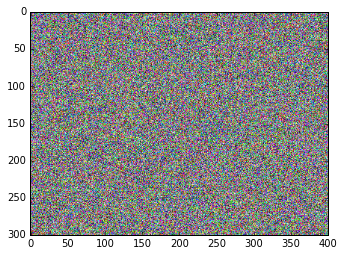

In [29]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [30]:
model = load_vgg_model("/home/pankaj/projects/neural style transfer/imagenet-vgg-verydeep-19.mat")

In [31]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [32]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [33]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style,  alpha = 10, beta = 40)
### END CODE HERE ###

In [34]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [35]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        _ = sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [36]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 1.80736e+11
content cost = 11640.4
style cost = 4.51841e+09
Iteration 20 :
total cost = 8.26995e+10
content cost = 31355.7
style cost = 2.06748e+09
Iteration 40 :
total cost = 4.09966e+10
content cost = 45455.3
style cost = 1.0249e+09
Iteration 60 :
total cost = 2.36402e+10
content cost = 53157.2
style cost = 5.90992e+08
Iteration 80 :
total cost = 1.52778e+10
content cost = 56541.7
style cost = 3.8193e+08
Iteration 100 :
total cost = 1.05797e+10
content cost = 58501.2
style cost = 2.64477e+08
Iteration 120 :
total cost = 7.71002e+09
content cost = 59748.0
style cost = 1.92736e+08
Iteration 140 :
total cost = 5.88602e+09
content cost = 60639.0
style cost = 1.47135e+08
Iteration 160 :
total cost = 4.66959e+09
content cost = 61314.1
style cost = 1.16725e+08
Iteration 180 :
total cost = 3.80655e+09
content cost = 61895.2
style cost = 9.51482e+07


array([[[[ -50.31638718,  -20.80032921,   44.43756104],
         [  -9.30516434,    1.48222053,   41.51734543],
         [   1.85012448,    2.95356965,   52.49399567],
         ..., 
         [  77.52913666,  -48.5056839 ,  103.21031189],
         [  59.8860321 ,  -34.17156982,  101.70936584],
         [  82.69747162,   74.53442383,  132.22903442]],

        [[ -16.39546776,   -2.89447999,   31.33077049],
         [  -2.38462543,  -11.0718441 ,   11.87795925],
         [   7.18381262,   -1.48507059,   27.4363327 ],
         ..., 
         [  73.34075165,  -42.68805313,   64.68108368],
         [  55.56216812,  -28.95509911,   94.25582886],
         [  88.79627228,   53.40377426,  120.43118286]],

        [[  48.20603561,   27.26797676,   52.04869843],
         [  13.74338055,   14.26978207,   38.406147  ],
         [  38.51337051,    1.93336427,   36.89544678],
         ..., 
         [  75.17240906,  -18.81040192,    3.09265947],
         [  37.20188904,   -0.9384023 ,   33.67468643],

# 5 - Conclusion
Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them!

Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
It uses representations (hidden layer activations) based on a pretrained ConvNet.
The content cost function is computed using one hidden layer's activations.
The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
Optimizing the total cost function results in synthesizing new images.
References:
The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team.
<br>
### References
- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576)
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/